#Graph Analytics e Data Wranglling su Rotten Tomato Reviews

In [ ]:
from math import nan
import re
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import shutil

#Download e creazione del dataset tramite kaggle

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'YOUR_USER'
os.environ['KAGGLE_KEY'] = 'YOUR_KEY'


In [ ]:
!pip install kaggle


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/82.1 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/82.1 kB ? eta -:--:--
     -------------- ----------------------- 30.7/82.1 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 82.1/82.1 kB 659.2 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/18/eb/fdb7eb9e48b7b02554e1664afd3bd3f117f6b6d6c5881438a0b055554f9b/tqdm-4.66.4-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.2 MB/s eta 0:00:00
  Obtaining depende

In [ ]:
!kaggle datasets download -p ./data -d andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews  --unzip

Dataset URL: https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews
License(s): CC0-1.0




  0%|          | 0.00/152M [00:00<?, ?B/s]
  1%|          | 1.00M/152M [00:00<01:04, 2.44MB/s]
  2%|1         | 3.00M/152M [00:00<00:27, 5.70MB/s]
  3%|3         | 5.00M/152M [00:00<00:20, 7.65MB/s]
  5%|4         | 7.00M/152M [00:00<00:16, 8.98MB/s]
  5%|5         | 8.00M/152M [00:01<00:16, 9.21MB/s]
  7%|6         | 10.0M/152M [00:01<00:15, 9.91MB/s]
  8%|7         | 12.0M/152M [00:01<00:13, 10.6MB/s]
  9%|9         | 14.0M/152M [00:01<00:13, 10.7MB/s]
 11%|#         | 16.0M/152M [00:01<00:12, 11.0MB/s]
 12%|#1        | 18.0M/152M [00:02<00:12, 11.1MB/s]
 13%|#3        | 20.0M/152M [00:02<00:12, 11.2MB/s]
 14%|#4        | 22.0M/152M [00:02<00:12, 11.2MB/s]
 16%|#5        | 24.0M/152M [00:02<00:11, 11.2MB/s]
 17%|#7        | 26.0M/152M [00:02<00:11, 11.4MB/s]
 18%|#8        | 28.0M/152M [00:02<00:11, 11.2MB/s]
 20%|#9        | 30.0M/152M [00:03<00:11, 11.2MB/s]
 21%|##1       | 32.0M/152M [00:03<00:11, 11.2MB/s]
 22%|##2       | 34.0M/152M [00:03<00:11, 11.2MB/s]
 24%|##3       | 36.

In [ ]:
df=pd.read_csv('./data/rotten_tomatoes_movie_reviews.csv')

#Exploratory Data Analysis e Data Wrangling

Il dataset proposto contine cirtca 1 400 000 recensioni provenienti dalla piattaforma Rotten Tomatoes riguardanti film usciti nel corso degli anni sia al cinema che rilasciati su piattaforme di streaming.

I dati sono per lo più in formato stringa e la sfida principare sarà interagire con i diversi input lasciati dagli utenti della piattaforma senza un controllo nel formato, specialmente per quanto riguarda lo score assegnato ad un film.

Il dataset è diviso in due file: uno che contiene le reviews in se e il secondo che invece contiene dettagli riguardanti i film nell'archivio che verrà utilizzato per aggiungere informazioni al modello prima di caricarlo in neo4j.

Per esperienza diretta da un progetto alla triennale estrapolare informazioni anche da un database relativamente semplice allo scopo di compiere analisi e fare reccomendation sia di tipo user-based può essere tutt'altro che banale e molto costoso.
Rappresentare i grafi in una rate permetti di avere direttamente dalla struttura dei dati tutte le informazioni necessarie per questi procedimenti.

Nel caso dei reccomendation system user based non fanno altro che costruire una tabella di adiacenza da un database relazionale e usarla per fare calcoli di similarità tra utenti; struttura dati che però deve essere aggiornata adll'aggiunta di un nuovo utente o di un nuovo contenuto della piattaforma con la quale ha interagito.
Queste operazioni stremamente costose specie nel contesto Big Data sono letteralmente le fondamenta su cui i sistemi NoSql Graph based sono fondati e tramite i quali si può arrivare direttamente ai dati di interesse senza dover fare continuo preprocessing.

In [ ]:
df.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


In [ ]:
print(f"Dimensioni dataset {df['reviewId'].size}")
for column in df.columns:
    print(f"Valori unici per colonna {column} : {df[column].unique().size}")

Dimensioni dataset 1444963
Valori unici per colonna id : 69263
Valori unici per colonna reviewId : 1432569
Valori unici per colonna creationDate : 8510
Valori unici per colonna criticName : 15510
Valori unici per colonna isTopCritic : 2
Valori unici per colonna originalScore : 1730
Valori unici per colonna reviewState : 2
Valori unici per colonna publicatioName : 2707
Valori unici per colonna reviewText : 1359772
Valori unici per colonna scoreSentiment : 2
Valori unici per colonna reviewUrl : 1138351


In [ ]:
#Approssimazione iniziale delle dimensioni del graph dataset
nodi = df["criticName"].unique().size + df["id"].unique().size
archi = df["reviewId"].unique().size

print(f"Reviews = G(N={nodi},L={archi})")

Reviews = G(N=84773,L=1432569)


In [ ]:
#Degree distribution (recensori)
degree = df["criticName"].value_counts()
print(f"Grado minimo: {degree.min()}")
print(f"Grado massimo: {degree.max()}")

Grado minimo: 1
Grado massimo: 13274


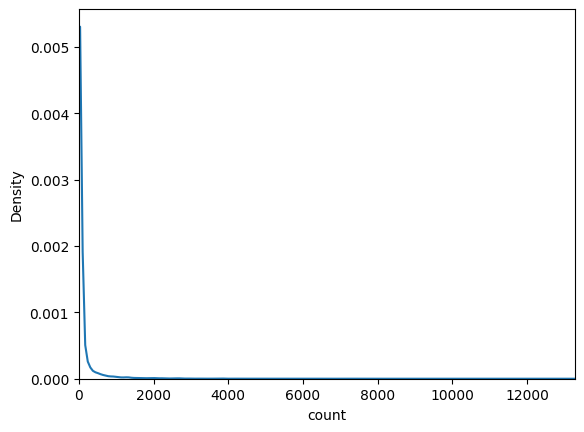

In [ ]:
#Plot Distribuzione
dist = sns.kdeplot(degree)
dist.set_xlim(0,13274)
plt.show()

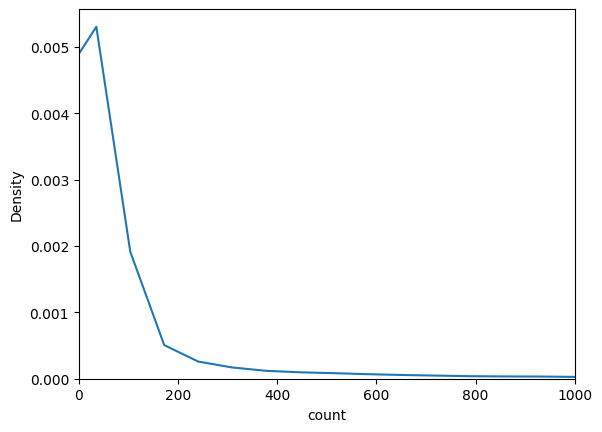

In [ ]:
#"Zoom" sulla parte centrale del grafo"
dist = sns.kdeplot(degree)
dist.set_xlim(0,1000)
plt.show()

In [ ]:
#Controllo su diverse formati dello score dato a un film
df["originalScore"].describe()

count     1009745
unique       1729
top           3/5
freq       116711
Name: originalScore, dtype: object

Lo sìil campo originalScore è in formato è una stringa che contiene voti assegnati in vari formati diversi: numerici, su scala voto/max_vote, scritti in lettere, alfabetici (A;B;C;D...) e con eventuali modificatori "+" e "-" o altri casi unici e/o fuori qualunque scala.

Per gestire l'ambiguità e normalizzare questi punteggi di apprezzament del film è necessario convertirli in un formato omogeneo e riscalarli in un intervallo comune: [0 1].

Tuttavia non si può effettuare prima una conversione numerica e poi un unica normalizzazione poichè valori troppo distanti fra loro creerebbero una distorsione nel risultato.

Si potrebbero rimuovere gli outliers ma dol momento che il contesto di "giudizio su un film" ci permette di ragionare allo stesso modo su scale di punteggio diverse è più opportuno applicare una correzzione ad hoc per le classi principali di voto:

**Voto numerico asoluto: 5, 10, -8 ...**: in questo caso possiamo applicare una correzzione convertendo il valore a float e poi dividendolo su quello che stimiamo potrebbe essere il valore stimato più appropriato.

Per alcuni casi ciò risulta banale come un 7 che possiamo assumere rappresentare un voto in decimi o 80 uno in centesimi; mentre per punteggi spropositamente alti o bassi è conveniente assumere il massimo o il minimo, rispettivamentente 0 e 1.

Per punteggi più ambigui, ovvero minori di 5, utilizziamo ul sentiment della recensioni per stimare la scala appropriata: se un 5 o un 3 sono associati ad un sentimento positivo allora probabilmente il voto è da considerare in quinti, mentre se è negativo è più probabile che una scala in decimi sia più appropriata.
Stesso raginamenti si può applicare per voti vicini al 10 che potrebbero essere in decimi o in centesimi e voti vicini all 100 che potrebbero essere in centesimi o millesimi (si se ne sono incontrati nel dataset)

**Voto numerico in scala: 5/5, 7/10, 80/100...**: nel caso sia fornita direttamente la scala allora ci troviamo in una situazione facilitata dove per ottenere uno score compreso tra 0 e 1 ci basta calcolare il risultato della frazione.
Per una questione di chiarità evitiamo di considerare un + o un - perchè non sarebbe chiaro se da applicare solo al denominatore o al voto complessivo.

**Voto alfabetico: A, B, C, A-, +A**: per questi voti dopo una breve analisi si è stabilito che rientrano quasi tutti nell'intervallo A - E quindi è stata scelta una scala di conversione decrescente da 1 a 0 con step di 0.25 non considerando eventuali valori più bassi della lettera e o modificatori + e - perche troppo ambigui (-A indica un voto negativo o quasi massimo? c'è trobba ambiguità per stabilirlo).

**Voto generale**: nel caso non sia possibile effettuare una conversione con i metodi precedenti viene assegnato uno score unicamente in base al sentiment della recensione associando 0.2 a NEGATIVE e O.8 a POSITIVE

In [ ]:
regex = re.compile('[^a-zA-z]')

#controllo voto alfabetico (A;B;C;D;E;A-;+B...)
def convert_score_alphabetic(valore):
    valore = valore.lower()
    #rimozione caratteri non alfabetici, per semplicità si converte solo il numero ignorando a eventuali + o -
    valore = regex.sub('', valore)

    score_numeroco = nan
    if valore == 'a':
        score_numeroco = 1.0
    elif valore == 'b':
        score_numeroco = 0.75
    elif valore == 'c':
        score_numeroco = 0.5
    elif valore == 'd':
        score_numeroco = 0.25
    elif valore == 'e':
        score_numeroco = 0.0

    #se non sono state identificate lettere, restituisco nan come segnalatore
    return score_numeroco

    #nel caso il voto sia un valore numerico
def convert_pure_number(valore,score_stringa):
    #bisogna differenziare cosa intendeva l'utente, possiamo assumere le seguenti scale:
    # 0 - 5
    # 0 - 10
    # 0 - 100
    #la prima e la seconda si intersecano, per fare un approssimazione è necessario basarsi sul sentimento
    score_numerico = float(valore)
    if not np.isnan(score_numerico):
        #se il voto e <= a 5 ma comunque positivo assumiamo che sia in scala 0 -5
        if score_numerico <= 5:
            if score_stringa == "POSITIVE":
                score = score_numerico / 5
                #se il voto e <= a 5 e negativp assumiamo che sia in scala 0 - 10
            else:
                score = score_numerico / 10
        elif score_numerico < 10:
            score = score_numerico/10
        elif score_numerico <= 100:
            score = score_numerico / 100
        else:
            score = score_numerico / 1000

        return score

def create_floatScore(valore, score_sentiment):
    #Creo un voto di default a partire sallo score sentiment nel caso non sia possibile convertire l'original score
    default_score = 0.2
    if score_sentiment == "POSITIVE":
        default_score = 0.8
    #converto a stringa nel caso sia un numero
    valore = str(valore)
    #tento conversione voto alphabetica
    score_numerico = convert_score_alphabetic(valore)
    if not np.isnan(score_numerico):
        return score_numerico

    #non è un voto alfabetico, procedo col controllo numerico
    #Tento conversione con voalore in formato voto/voto_max
    try:
        if "/" in valore:
            valore_list = valore.split("/")
            #ignoro eventuali + o - al punteggio
            score = abs(float(valore_list[0])/float(valore_list[1]))
            #il voto deve essere compreso tra 0 e 1
            if score > 1:
                score = 1.
            elif score < 0:
                score = 0.
            return score
    except:
        pass

    #Tento la conversione di un numero puro
    try:
        score = convert_pure_number(valore,score_sentiment)
        #se non viene restituito un numero nel valore 0 1 significa che il numero è troppo ambiguo per essere convertito
        if score >= 0 and score >= 1:
            return score
    except:
        pass

    #Se non si è riuscito ad applicare alcuna conversione allora ci si basa su un valore di default assegnato tramite sentiment:
    return default_score

df['scoreFloat'] = df.apply(lambda x: create_floatScore(x['originalScore'], x['scoreSentiment']), axis=1)

In [ ]:
print(f"Score non convertiti: {df['scoreFloat'].isna().sum()}")
print(f"Review senza score_sentiment: {df['scoreSentiment'].isna().sum()}")

Score non convertiti: 0
Review senza score_sentiment: 0


Dopo che gli score delle recensioni sono state sistemati prendiamo il secondo file del dataset di kaggle per incorporare ulteriori informazioni sui film recensiti e poter fare ulteriore pulizia.

In [ ]:
movies = pd.read_csv('./data/rotten_tomatoes_movies.csv')
movies.head()

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
1,the_green_grass,The Green Grass,NaN,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Tiffany Edwards,Tiffany Edwards,NaN,NaN,NaN
2,love_lies,"Love, Lies",43.0,NaN,NaN,NaN,NaN,NaN,120.0,Drama,Korean,"Park Heung-Sik,Heung-Sik Park","Ha Young-Joon,Jeon Yun-su,Song Hye-jin",NaN,NaN,NaN
3,the_sore_losers_1997,Sore Losers,60.0,NaN,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,John Michael McCarthy,John Michael McCarthy,NaN,NaN,NaN
4,dinosaur_island_2002,Dinosaur Island,70.0,NaN,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Will Meugniot,John Loy,NaN,NaN,NaN


In [ ]:
#Merge col secondo dataset
df_merged = df.merge(
    right = movies,
    on = "id",
)
#rimozione colonne non utili
df_merged = df_merged[
    ["id",
     "reviewId",
     "creationDate",
     "criticName",
     "isTopCritic",
     "reviewState",
     "scoreSentiment",
     "scoreFloat",
     "title",
     "releaseDateStreaming",
     "releaseDateTheaters",
     "runtimeMinutes",
     "genre"]
]

Per pulire la data di una creazione di una recensioni possiamo applicare 3 controlli per restare coerenti col dataset:

Il primo è verificare se una recensione è stata creata dopo l'uscita nelle piattaforme online, releaseDateStreaming, di un film, se il valore è disponibile.

Il primo è verificare se una recensione è stata creata dopo l'uscita nelle sale cinematografiche, releaseDateTheaters, di un film, se il valore è disponibile.

Senza questi due valori non abbiamo modo di garantire l'integrità della data di creazione della recensione e dunque assegniamo il valore 1800-01-01 che dal datase è usato come null value.

**Nota:** alcune recensioni sono state fatte con una data antecedente alla creazione della piattaforma Rotten Tomato, ma questo non è proibito poichè la piattaforma ha caricato recensioni di critici storici riguardanti film d'epoca precendnti all'era dello streaming online e dunque sono considerabili dati sensati che non possono essere esclusi a priori.



In [ ]:
#Correzzione creationDate della review
def adjust_creation_date(creationDate,releaseDateStreaming,releaseDateTheaters):
    #se una recensione non ha una data di creazione valida (minore del caricamento del film) allora
    #viene sostituita dalla di rilascio del film cheè la prima logica dalla quale una recensione su di esso
    #può esistere.
    #il formato stringhe permette di fare un confronto diretto
    #setto il valore di default al minimo del datavase
    new_date = creationDate
    #do la precedenza alla data di rilascio nei cinema se esiste lasciando sovrascrivere la data di rilascio streaming
    if not pd.isnull(releaseDateStreaming) and creationDate < releaseDateStreaming:
        new_date = releaseDateStreaming
    elif not pd.isnull(releaseDateTheaters) and creationDate < releaseDateTheaters:
        new_date = releaseDateTheaters
    else:
        new_date = "1800-01-01"

    #se non c'è almeno una data di rilascio non posso verificare la data
    return new_date

df_merged['scoreFloat'] = df_merged.apply(lambda x: adjust_creation_date(x['creationDate'],x['releaseDateStreaming'], x['releaseDateTheaters']), axis=1)

Per correggere l'assenza di un movieTitle utilizziamo il suo id che è composto dalle parole del titolo minuscole e collegate dal carattere "_".
Quindi utilizzando uno split si può ottenere in maniera immediata una buona approssimazione.

In [ ]:
#Correzzione dei movietitle mancanti
def adjust_title(title,movieId):
    #se il title è a null lo sostituisco con l'id poichè nel database è comunque una stringa significativa
    if pd.isnull(title):
        split_id = movieId.split("_")
        split_id = " ".join(split_id)
        return split_id

    return title

df_merged['title'] = df_merged.apply(lambda x: adjust_title(x['title'],x['id']), axis=1)

La colonna runtimeMinutes non è approssimabile mediante similarità con altre entry poichè ogni film è unico e realizzato con criteri e scopi diversi così come diverse durate.

L'approssimazione migliore che si può fare è utilizzare la durata media di una pellicola e tenere a mente che senza coinvolgere ulteriori dataset non sarà un attributo affidabile in fase id Data Analysis.

In [ ]:
#Per riempire i runtimeminutes non potendo fare paragone di similarità con altri film utilizziamo il valore 0
avg = df_merged['runtimeMinutes'].mean()
df_merged["runtimeMinutes"] = df_merged['runtimeMinutes'].fillna(avg)

In [ ]:
#Revisione del dataset
for col in df_merged.columns:
    print(f"Nan in {col} : {df_merged[col].isna().sum()}")

Nan in id : 0
Nan in reviewId : 0
Nan in creationDate : 0
Nan in criticName : 0
Nan in isTopCritic : 0
Nan in reviewState : 0
Nan in scoreSentiment : 0
Nan in scoreFloat : 0
Nan in title : 0
Nan in releaseDateStreaming : 113821
Nan in releaseDateTheaters : 285473
Nan in runtimeMinutes : 0
Nan in genre : 23450


Siamo in una situazione di dati sufficientemente puliti a procedere con la crazione del database, le mancanze in genre non rappresentano un problema per le operazioni di data analysis del progetto.

#Creazione database Neo4j

Lo schema del grafo risulta molto semplice:

(cr:Critic)-[r:REVIEW]->(mv:Movie)

E raccoglie le recensioni degli utenti della piattaforma associandole direttamente al film.
Di conseguenza questo grafo sarà composto da varie componenti a *stella*, alcune di enormi dimensini che si collegano ai film più popolari e altre di dimensioni più modeste.

Un'altra conseguenza è che non ci possono essere path più lunghi di un salto a meno di non considera una proiezione con link undirected.

Questa struttura limita il numero di algoritmi di graph analytics che si possono applicare per ottenere informazioni rilevanti e a titolo personale col senno di poi sarebbe stato opportuno selezionare con una struttura di maggiore interesse.

**Schema**

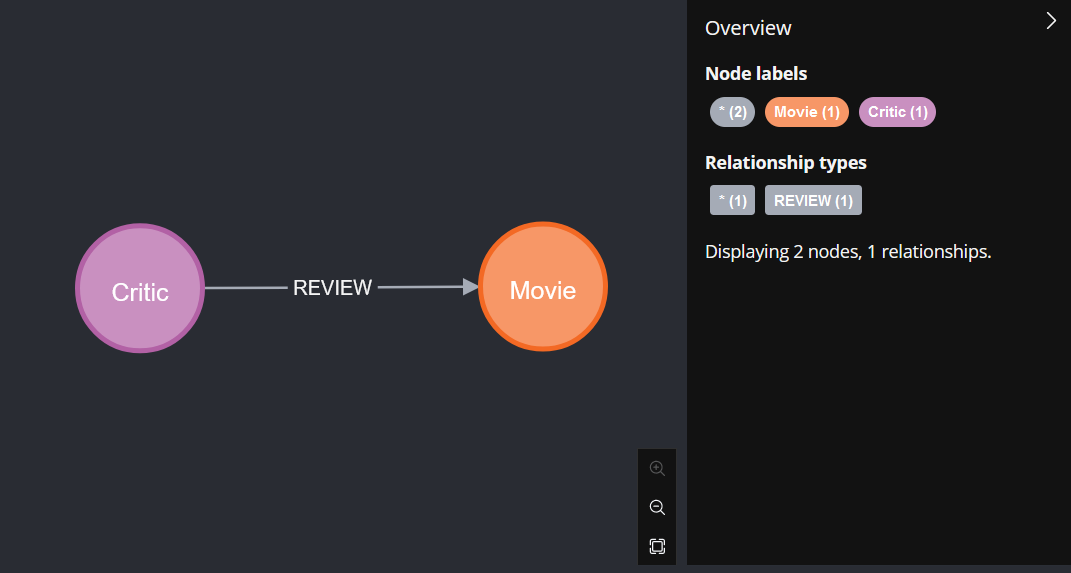

**Rappresentazione di un sample del grafo**:

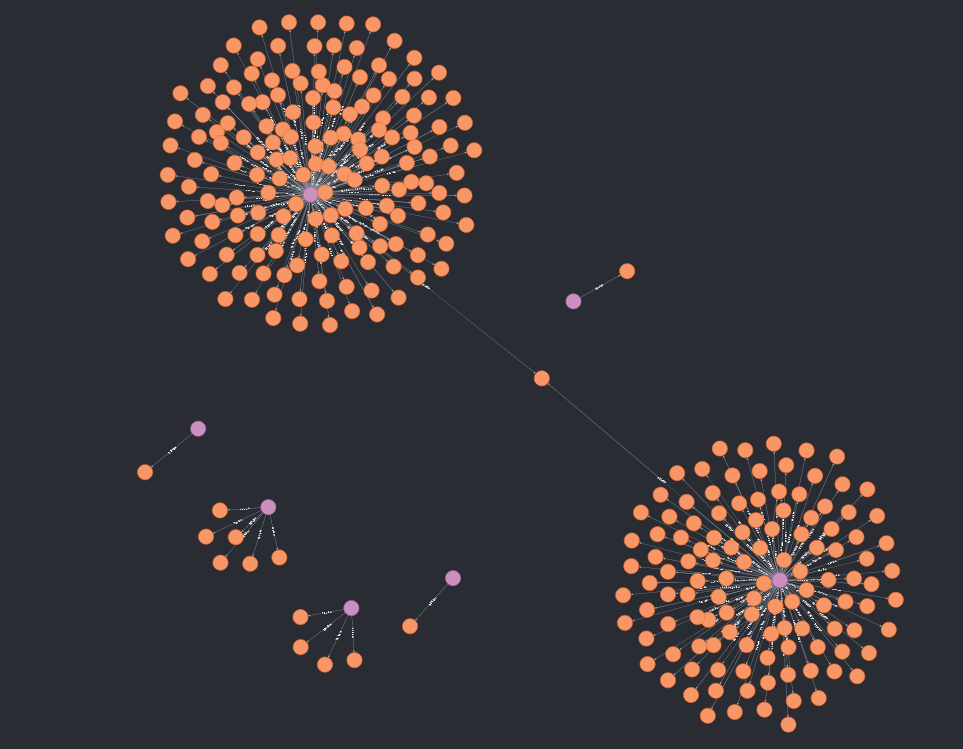

Per quanto riguarda le properties distinguamo le seguenti per ogni nodo:

**Critic**:
*  criticNumId: Un campo aggiunto come supporto per interagire con le proiezioni
*  criticName: l'id univoc del critico corrispondente ad un username con cui identificarlo
*  isTop: booleano che indica se il critico è riconosciuto dalla piattaforma come top critic

**Movie**:
*  movieNumId: Un campo aggiunto come supporto per interagire con le proiezioni
*  movieId: id univoco del film, può essere anche rappresentativo del titolo (es district_9 per il film District 9)
*  movieTitle: Il titolo del film
*  releaseDateTheaters: data di rilascio nei cinema
*  runtimeMinutes: durata in minuti
*  genre: lista dei generi di appartenenza in formato stringa, mantenuta in questo stato poichè tramite l'operatore **in** è sempice verificare se un genere è contenuto nella lista del film

Proprietà dei link:

**Reviews**:
*  reviewNumId: Un campo aggiunto come supporto per interagire con le proiezioni
*  reviewId: id univoco della recensione
*  creationDate: data creazione della recensione
*  scoreSentiment: sentimento della recensione, può essere POSITIVE o NEGATIVE, è stato tenuto in formato stringa per mantenere un espressività immediata anche in fase di query
*  scoreFloat: punteggio numerico tra 0 e 1 associato al alla recensione

Creazione liste di film dalla colonna id e dei recensori dalla colonna criticName

In [ ]:
#Non ci sono entry senza titolo o criticName dunque posso passare direttamente
#alla creazione del set senza dover ripulire quei campi
print(f"Recensioni senza film: {df_merged['id'].isna().sum()}")
print(f"Recensioni senza nome recensore: {df_merged['criticName'].isna().sum()}")
#usando dei set l'insieme non conterrà ripetizioni
films_titles = set(df_merged['id'])
critics_names = set(df_merged['criticName'])
print(f"Numero film: {len(films_titles)}")
print(f"Numero recensori: {len(critics_names)}")

Recensioni senza film: 0
Recensioni senza nome recensore: 0
Numero film: 69260
Numero recensori: 15509


Creazione di alcuni dizionari di supporto per la creazione del dataset

In [ ]:
#Creazione dizionari critcName : isTop
dict_critic_top = df_merged.set_index("criticName")["isTopCritic"].to_dict()
#Creazione dizionarion id: "title","releaseDateTheaters","runtimeMinutes","genre"
dict_movie_title = df_merged.set_index("id")["title"].to_dict()
dict_movie_date = df_merged.set_index("id")["releaseDateTheaters"].to_dict()
dict_movie_runt = df_merged.set_index("id")["runtimeMinutes"].to_dict()
dict_movie_genre = df_merged.set_index("id")["genre"].to_dict()

Creazione file da importare in Neo4J

In [ ]:
#Creazione file critici
shutil.rmtree("csv-dump")
os.mkdir("csv-dump")
count = 0
with open('./csv-dump/critics.csv', encoding='utf-8',mode='w', newline='') as critics_file:
    #definizione header
    writer = csv.DictWriter(critics_file, fieldnames=["criticNumId","criticName", "isTop"])

    for critic in critics_names:
        critico = {
            "criticNumId" : count,
            "criticName"  : critic,
            "isTop"       : bool(dict_critic_top[critic])
        }
        writer.writerow(critico)
        count = count+1

#Creazione file movies
count = 0
with open('./csv-dump/movies.csv', encoding='utf-8', mode='w', newline='') as movies_file:
    #definizione header
    writer = csv.DictWriter(movies_file, fieldnames=["movieNum_id","movieId","movieTitle","releaseDateTheaters","runtimeMinutes","genre"])

    for movie in films_titles:
        movie = {
            "movieNum_id"         : count,
            "movieId"             : movie,
            "movieTitle"          : dict_movie_title[movie],
            "releaseDateTheaters" : dict_movie_date[movie],
            "runtimeMinutes"      : dict_movie_runt[movie],
            "genre"               : dict_movie_genre[movie]
        }
        writer.writerow(movie)
        count = count + 1

#creazione file reviews
count = 0
with open('./csv-dump/reviews.csv', encoding='utf-8', mode='w', newline='') as reviews_file:
    #definizione header
    writer = csv.DictWriter(reviews_file, fieldnames=["reviewNumId", "criticName", "movieTitle", "reviewId", "creationDate", "scoreSentiment", "scoreFloat"])

    for id in df.index:
        review = {
            "reviewNumId"     : count,
            "criticName"      : df["criticName"][id],
            "movieTitle"      : df["id"][id],
            "reviewId"        : df["reviewId"][id],
            "creationDate"    : df["creationDate"][id],
            "scoreSentiment"  : df["scoreSentiment"][id],
            "scoreFloat"      : df["scoreFloat"][id]
        }
        writer.writerow(review)
        count = count+1


**IMPORTANTE:**Prima di procedere è necessario creare e avviare un database locale di neo4j  cui connettersi e installare i plug in APOC e GDS per poter eseguire tutte le queri successive.

Creazione Critics e index critics

In [ ]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j://localhost"
AUTH = ("neo4j", "pomodoro")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

    # Get the name of all 42 year-olds
    driver.execute_query("MATCH (c:Critic) DELETE c")
    records, summary, keys = driver.execute_query(
        "LOAD CSV FROM 'file:///critics.csv' AS row MERGE (a:Critic {criticNumId: toInteger(row[0]), criticName: row[1], isTop:toBoolean(row[2])}) RETURN a.criticName, a.isTop Limit 10"
    )

    # Loop through results and do something with them
    for movie in records:
        print(movie)

    # Summary information
    print("The query `{query}` returned {records_count} records in {time} ms.".format(
        query=summary.query, records_count=len(records),
        time=summary.result_available_after,
    ))
    #Creazione index

    driver.execute_query("DROP INDEX critic_criticName_index IF EXISTS")
    driver.execute_query("CREATE INDEX critic_criticName_index FOR (c:Critic) ON (c.criticName)")

    driver.close()

<Record a.criticName='Olivia Cathcart' a.isTop=False>
<Record a.criticName='Michael Kostelnuk' a.isTop=False>
<Record a.criticName='Leo Seligsohn' a.isTop=True>
<Record a.criticName='Chinelo Anyadiegwu' a.isTop=True>
<Record a.criticName='George Elkind' a.isTop=False>
<Record a.criticName='Madison Brek' a.isTop=False>
<Record a.criticName='David Medsker' a.isTop=False>
<Record a.criticName='Billie Cohen' a.isTop=True>
<Record a.criticName='Kenneth Broome' a.isTop=False>
<Record a.criticName='Garrett Green' a.isTop=False>
The query `LOAD CSV FROM 'file:///critics.csv' AS row MERGE (a:Critic {criticNumId: toInteger(row[0]), criticName: row[1], isTop:toBoolean(row[2])}) RETURN a.criticName, a.isTop Limit 10` returned 10 records in 2 ms.


Creazione Movies e Index movies

**Nota Allo Sviluppo**: non so perchè ma l'esecuzione tramite driver delle queri che iniziano con : non funziona e cypher segnala un errore di sintassi,la stessa query lanciata da terminale cypher funziona perfettamente.
Non sono riuscito a rintracciare la causa dell'errore quindi si lancino manualmente da terminale le query di creazione dei film e delle reviews.

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

    # Get the name of all 42 year-olds
    driver.execute_query("MATCH (m:Movie) DELETE m")
    records, summary, keys = driver.execute_query(
            """:auto LOAD CSV FROM 'file:///movies.csv' AS row
            CALL{WITH row MERGE (m:Movie {movieNumId: toInteger(row[0]), movieId: row[1], movieTitle: row[2], releaseDateTheaters: row[3], runtimeMinutes: toFloat(row[4]), genre: row[5]})
            }IN TRANSACTIONS OF 1000 ROWS"""
    )

    # Summary information
    print("The query `{query}` returned {records_count} records in {time} ms.".format(
        query=summary.query, records_count=len(records),
        time=summary.result_available_after,
    ))

    driver.execute_query("DROP INDEX movie_movieId_index IF EXISTS")
    driver.execute_query("CREATE INDEX movie_movieId_index FOR (m:Movie) ON (m.movieId)")

    driver.close()

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input ':': expected
  "ALTER"
  "CALL"
  "CREATE"
  "DEALLOCATE"
  "DELETE"
  "DENY"
  "DETACH"
  "DROP"
  "DRYRUN"
  "ENABLE"
  "FOREACH"
  "GRANT"
  "INSERT"
  "LOAD"
  "MATCH"
  "MERGE"
  "NODETACH"
  "OPTIONAL"
  "REALLOCATE"
  "REMOVE"
  "RENAME"
  "RETURN"
  "REVOKE"
  "SET"
  "SHOW"
  "START"
  "STOP"
  "TERMINATE"
  "UNWIND"
  "USE"
  "USING"
  "WITH" (line 1, column 1 (offset: 0))
":auto LOAD CSV FROM 'file:///movies.csv' AS row"
 ^}

Create Reviews

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

    # Get the name of all 42 year-olds
    driver.execute_query(":auto CALL{MATCH ()-[r:REVIEWS]->() DELETE r}IN TRANSACTIONS OF 1000 ROWS")
    records, summary, keys = driver.execute_query(
        """:auto
            LOAD CSV FROM 'file:///reviews.csv' AS row
            CALL{
                WITH row
                MATCH (c:Critic {criticName:row[1]}), (m:Movie {movieId: row[2]})
                MERGE (c)-[:REVIEW {reviewNumId: toInteger(row[0]),reviewId:row[3], creationDate:row[4], scoreSentiment:row[5], scoreFloat:toFloat(row[6])}]->(m)
            }IN TRANSACTIONS OF 1000 ROWS"""
    )

    # Summary information
    print("The query `{query}` returned {records_count} records in {time} ms.".format(
        query=summary.query, records_count=len(records),
        time=summary.result_available_after,
    ))

    driver.close()

#Domande con risoluzione applicate a Neo4j

**DOMANDA 1**

Un primo punto di interesse per studiare la rete di recensioni e capirne le dinamiche è valutare il grado dei nodi per identificare quali sono i recensori più prolifici; sia che vengano considerati rilevanti dalla piattaforma Rotten Tomato che di quelli più comuni.

Possiamo aggiunfere ai risultati anche gli intervalli di pubblicazione delle recensioni così da poter osservare se un individuo avesse pubblicato un numero di volte eccessivamente alto rispetto al periodo di tempo nel qualeè stato attivo.

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    records, summary, keys = driver.execute_query(
        """
        match (cr:Critic)-[r:REVIEW]->()
        return cr.criticName, min(r.creationDate) as firstReview, max(r.creationDate) as lastReview, count(r) as nReview
        order by nReview Desc limit 10
        """
    )
    # Loop through results and do something with them
    for movie in records:
        print(movie)

    driver.close()

<Record cr.criticName='Emanuel Levy' firstReview='2000-01-01' lastReview='2022-05-26' nReview=13273>
<Record cr.criticName='Dennis Schwartz' firstReview='2000-01-01' lastReview='2023-04-08' nReview=13123>
<Record cr.criticName='Roger Moore' firstReview='1990-08-24' lastReview='2023-04-08' nReview=8411>
<Record cr.criticName='Roger Ebert' firstReview='1800-01-01' lastReview='2023-03-15' nReview=7364>
<Record cr.criticName='Brian Orndorf' firstReview='2000-01-01' lastReview='2023-04-06' nReview=7068>
<Record cr.criticName='Jeffrey M. Anderson' firstReview='2000-01-01' lastReview='2023-04-07' nReview=7051>
<Record cr.criticName='David Nusair' firstReview='2000-01-01' lastReview='2023-04-08' nReview=7013>
<Record cr.criticName='Frank Swietek' firstReview='1995-06-30' lastReview='2023-04-07' nReview=6727>
<Record cr.criticName='Rich Cline' firstReview='2001-12-10' lastReview='2023-04-04' nReview=6337>
<Record cr.criticName='Frederic and Mary Ann Brussat' firstReview='2000-01-01' lastReview=

Abbiamo ottenuto i critici più attivi e nessuno mostra un periodo di tempo di attività troppo breve da far sospettare dell'autenticità dall'account.

**DOMANDA 2**

Una domanda analoga alla precedente è identificare i film più visti all'interno del database.
Possiamo introdurre una distinzione: considerare tutti i recensori oppure solo quelli considerati topCritic ovvero che la piattaforma Rotten Tomatoes reputa più rilevanti secondo criteri propri di attività, riconoscimento dell'account e altre metriche.

Poi possiamo paragonare i due risultati per vedere le differenze:

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    records, summary, keys = driver.execute_query(
        """
        match (cr:Critic)-[r:REVIEW]->(m:Movie)
        where cr.isTop = false
        return m.movieId, m.movieTitle, count(r) as nRevs
        order by nRevs desc
        limit 10
        """
    )
    # Loop through results and do something with them
    print("Top 10 Films considerando tutti i critici")
    all_movies = []
    for movie in records:
        print(movie)
        all_movies.append(movie[0])

    driver.verify_connectivity()
    records, summary, keys = driver.execute_query(
        """
        match (cr:Critic)-[r:REVIEW]->(m:Movie)
        where cr.isTop = true
        return m.movieId, m.movieTitle, count(r) as nRevs
        order by nRevs desc
        limit 10
        """
    )
    # Loop through results and do something with them
    print("--------------------------------------------")
    print("Top 10 Films considerandosolo i critici Top:")
    top_movies = []
    for movieTop in records:
        print(movieTop)
        top_movies.append(movieTop[0])

Top 10 Films considerando tutti i critici
<Record m.movieId='parasite_2019' m.movieTitle='Parasite' nRevs=768>
<Record m.movieId='ant_man_and_the_wasp_quantumania' m.movieTitle='Ant-Man and The Wasp: Quantumania' nRevs=624>
<Record m.movieId='joker_2019' m.movieTitle='Joker' nRevs=488>
<Record m.movieId='once_upon_a_time_in_hollywood' m.movieTitle='Once Upon a Time... In Hollywood' nRevs=469>
<Record m.movieId='avengers_endgame' m.movieTitle='Avengers: Endgame' nRevs=457>
<Record m.movieId='captain_marvel' m.movieTitle='Captain Marvel' nRevs=454>
<Record m.movieId='black_panther_2018' m.movieTitle='Black Panther' nRevs=430>
<Record m.movieId='star_wars_the_rise_of_skywalker' m.movieTitle='Star Wars: The Rise of Skywalker' nRevs=430>
<Record m.movieId='a_star_is_born_2018' m.movieTitle='A Star Is Born' nRevs=424>
<Record m.movieId='the_batman' m.movieTitle='The Batman' nRevs=417>
--------------------------------------------
Top 10 Films considerandosolo i critici Top:
<Record m.movieId=

Si può vedere immediatamente che i risultati sono differenti e come nella prima query compiano più film popolari degli ultimi anni mentre nel secondo riltato figurano pellicole meno popolari ma che hanno anche ricevuto più premiazioni
Si possono contare i film in comune nei due insiemi per ottenere un risultato preciso

In [ ]:
print("Film comuni ai due risultati delle query")
print(set(all_movies).intersection(set(top_movies)))

Film comuni ai due risultati delle query
{'ant_man_and_the_wasp_quantumania', 'parasite_2019'}


**DOMANDA 3**

Critici Horror più rilevanti

Per valutare quali nodi abbiano una maggiore influenza all'interno di un genere cinematografico specifico sono necessari tre passaggi:

* Estrarre il sottografo delle critiche horror tramite graph projection
* Calcolare tramite misure di centralità gli horror più rilevanti in questo sottoinsieme
* Ordinare i film in ordine di misure di centralità

Data la struttura del database (critico)-REVIEW->(movie) è opportuno utilizzare misure di centralità basate sul grado di un nodo considerando quali hanno un influenza (numero di recensioni e quindi link) maggiore.

Per queste ragioni si è scelto di usare la funzione gds.degree.stream che calcola la degree centrality basandosi sull'outdregree

Crezione proiezione grafo per i film horror

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    try:
        records, summary, keys =driver.execute_query(
            """
                CALL gds.graph.drop('horrorRevs') YIELD graphName
            """
        )
    except:
        pass
    records, summary, keys =driver.execute_query(
        """
            MATCH (source:Critic)-[r:REVIEW]->(target:Movie)
            WHERE r.scoreSentiment = "POSITIVE" and "Horror" in target.genre
            WITH gds.graph.project(
                'horrorRevs',
                source,
                target,
                {
                    sourceNodeProperties: {criticNumId:source.criticNumId},
                    targetNodeProperties: {movieNumId:target.movieNumId}
                }
                )as g
            RETURN g.graphName AS graph, g.nodeCount AS nodes,g.relationshipCount AS rels
        """
    )

    records, summary, keys = driver.execute_query(
        """
        call gds.degree.stream('horrorRevs')
        yield nodeId, score
        RETURN gds.util.asNode(nodeId).criticName as criticName, score
        order by score desc limit 20
        """
    )
    # Summary information
    for mi_critic in records:
        print(mi_critic)

<Record criticName='Anton Bitel' score=321.0>
<Record criticName='Scott Weinberg' score=246.0>
<Record criticName='Dennis Schwartz' score=246.0>
<Record criticName='Ken Hanke' score=233.0>
<Record criticName='Felix Vasquez Jr.' score=192.0>
<Record criticName='Emanuel Levy' score=187.0>
<Record criticName='Jeffrey M. Anderson' score=170.0>
<Record criticName='Matt Brunson' score=155.0>
<Record criticName='Tim Brayton' score=127.0>
<Record criticName='Dustin Putman' score=103.0>
<Record criticName='Jennie Kermode' score=101.0>
<Record criticName='Fernando F. Croce' score=93.0>
<Record criticName='C.H. Newell' score=92.0>
<Record criticName='Rob Gonsalves' score=87.0>
<Record criticName='Kat Hughes' score=79.0>
<Record criticName='Cole Smithey' score=78.0>
<Record criticName='Brian Orndorf' score=78.0>
<Record criticName='Walter Chaw' score=77.0>
<Record criticName='Matt Donato' score=77.0>
<Record criticName='David Nusair' score=76.0>


Note:Questa ricerca esclude in automatico i film perchè essendo i nodi destinatari dei link DIRETTI non hanno archi in uscita e dunque ricevono uno score nullo dalla funzione invocata e vengono escluse dal limite sui risultati

**DOMANDA 4**

Film Horror più rilevanti

Per valutare la rilevanza di un film dobbiamo considerare quante recensioni lo riguardano e le dimensioni del gruppo di utenti che lo hanno recensito e il loro coinvolgimento nella comunity horror.

In altre parole ci serve valutare la centralità del nodo in funzione dei path di cui fa parte e quindi utilizzare una misura come la betweenness centrality con la funzione gds.betweenness.stream; più adatta a questo task rispetto alla degree centrality.

Inoltre è necessario filtrare i risultati sui movie perchè anche i nodi Critico con più archi, facendo parte di molti shortest paths (quelli che partono o che terminano con loro) e riceveranno uno score alto da questo metodo.


In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    try:
        records, summary, keys =driver.execute_query(
            """
                CALL gds.graph.drop('undirectedHorrorRevs') YIELD graphName
            """
        )
    except:
        pass
    records, summary, keys =driver.execute_query(
        """
            MATCH (source:Critic)-[r:REVIEW]->(target:Movie)
            WHERE r.scoreSentiment = "POSITIVE" and "Horror" in target.genre
            WITH gds.graph.project(
                'undirectedHorrorRevs',
                source,
                target,
                {
                    sourceNodeProperties: {criticNumId:source.criticNumId},
                    targetNodeProperties: {movieNumId:target.movieNumId}
                },
                {undirectedRelationshipTypes: ['*']}
                )as g
            RETURN g.graphName AS graph, g.nodeCount AS nodes,g.relationshipCount AS rels
        """
    )

    records, summary, keys = driver.execute_query(
        """
        call gds.betweenness.stream('undirectedHorrorRevs')
        yield nodeId, score
        where not gds.util.asNode(nodeId).movieId is null
        RETURN gds.util.asNode(nodeId).movieId as criricName, score
        order by score desc limit 10
        """
    )
    # Summary information
    for mi_films in records:
        print(mi_films)

<Record criricName='let_me_in' score=448928.04114027834>
<Record criricName='let_the_right_one_in' score=395866.8598411403>
<Record criricName='saint_maud' score=367068.6054560554>
<Record criricName='dawn_of_the_dead' score=253107.91030931062>
<Record criricName='hatching' score=206134.425352606>
<Record criricName='land_of_the_dead' score=175986.35425702116>
<Record criricName='1007818-frankenstein' score=165088.02449056448>
<Record criricName='carrie' score=153642.59551391224>
<Record criricName='blood_quantum' score=145298.90259661412>
<Record criricName='sleepy_hollow' score=136872.25779412896>


**DOMANDA 5**

Sistema di Reccomandation

E' possibile creare un sistema di raccomandazioni confrontando gli utenti che hanno preferenze simili in termini cinematografici.
Grazie alla struttura a grafo possiamo implementare direttamente un sistema user-based che utilizza un algoritmo di k-neighbors tramote query e ottenere le coppie di utenti più simili e quindi fare suggerimenti in base all'affinità di comportamento sulla piattaforma (ovvero di espressio di preferenza).

Dopo di che selezioniamo un critico della coppia e come suggerimentipossiamo prendere altri film che sono stati apprezzati da un suo "simile" e che lui non ha guardato.

Stavolta restringiamo il campo alla community attorno al genere Sci-fi


In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

    records, summary, keys =driver.execute_query(
        """
            match (cr1:Critic)-[r1:REVIEW]->(mv1:Movie)<-[r2:REVIEW]-(cr2:Critic)
            where "Sci-fi" in mv1.genre
                and cr1.criticName <> cr2.criticName
                and r1.scoreSentiment = "POSITIVE" and r2.scoreSentiment = "POSITIVE"
            return cr1.criticName, cr2.criticName, count(mv1) as commonMovies
            order by commonMovies DESC limit 50
        """
    )

    #estrazione coppie di nomi di utenti simili


In [ ]:
for critics in records:
    print(critics)

#Selezioniamo i primi due simili

node1 = records[0][0]
node2 = records[0][1]

<Record cr1.criticName='Ken Hanke' cr2.criticName='Emanuel Levy' commonMovies=61>
<Record cr1.criticName='Emanuel Levy' cr2.criticName='Ken Hanke' commonMovies=61>
<Record cr1.criticName='Emanuel Levy' cr2.criticName='Scott Weinberg' commonMovies=51>
<Record cr1.criticName='Scott Weinberg' cr2.criticName='Emanuel Levy' commonMovies=51>
<Record cr1.criticName='Dennis Schwartz' cr2.criticName='Ken Hanke' commonMovies=49>
<Record cr1.criticName='Ken Hanke' cr2.criticName='Dennis Schwartz' commonMovies=49>
<Record cr1.criticName='Ken Hanke' cr2.criticName='Scott Weinberg' commonMovies=46>
<Record cr1.criticName='Scott Weinberg' cr2.criticName='Ken Hanke' commonMovies=46>
<Record cr1.criticName='Dennis Schwartz' cr2.criticName='Emanuel Levy' commonMovies=43>
<Record cr1.criticName='Emanuel Levy' cr2.criticName='Dennis Schwartz' commonMovies=43>
<Record cr1.criticName='Ken Hanke' cr2.criticName='Matt Brunson' commonMovies=40>
<Record cr1.criticName='Matt Brunson' cr2.criticName='Ken Hanke' c

In [ ]:
print(node1," - ",node2)
#Estraiamo i nodi che sono stati visti dal primo nodo, ma non dal secondo
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    query = """
            match (cr1:Critic {criticName:'"""+node1+"""'})-[r1:REVIEW]->(mv1:Movie)<-[r2:REVIEW]-(cr2:Critic)
            where "Sci-fi" in mv1.genre
                and cr2.criticName <> '"""+node2+"""'
                and r1.scoreSentiment = "POSITIVE"
            return distinct mv1.movieTitle
        """

    records, summary, keys =driver.execute_query(
        query
    )

    for suggestion in records:
        print(suggestion)

Ken Hanke  -  Emanuel Levy
<Record mv1.movieTitle='Frankenstein Unbound'>
<Record mv1.movieTitle='Earth vs. the Flying Saucers'>
<Record mv1.movieTitle='The Four Sided Triangle'>
<Record mv1.movieTitle='Danger: Diabolik'>
<Record mv1.movieTitle='The Blob'>
<Record mv1.movieTitle='20 Million Miles to Earth'>
<Record mv1.movieTitle='King Kong vs. Godzilla'>
<Record mv1.movieTitle="The Invisible Man's Revenge">
<Record mv1.movieTitle='Looker'>
<Record mv1.movieTitle='Zardoz'>
<Record mv1.movieTitle='Beginning of the End'>
<Record mv1.movieTitle='Things to Come'>
<Record mv1.movieTitle='Earth vs. the Spider'>
<Record mv1.movieTitle='The Monster That Challenged the World'>
<Record mv1.movieTitle='This Island Earth'>
<Record mv1.movieTitle='Tarantula'>
<Record mv1.movieTitle='My Stepmother Is an Alien'>
<Record mv1.movieTitle='The Invisible Man'>
<Record mv1.movieTitle='Mothra'>
<Record mv1.movieTitle='Robinson Crusoe on Mars'>
<Record mv1.movieTitle='The Brother From Another Planet'>
<Recor

**DOMANDA 6**

Confronto dimensioni delle comunità.

L'ultima analisi proposta prevede confrontare le comunità di critici attorno ad un genere per scoprire quali occupano un opzione maggiore dell'utenza della piattaforma.

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    records, summary, keys = driver.execute_query(
        """
        MATCH (cr:Critic)-[r:REVIEW]->(mv:Movie)
        WHERE r.scoreSentiment = "POSITIVE" and "Romance" in mv.genre
        return count(cr)
        """
    )
    print(f"Dimensioni community romance: {records[0][0]}")
    records, summary, keys = driver.execute_query(
        """
        MATCH (cr:Critic)-[r:REVIEW]->(mv:Movie)
        WHERE r.scoreSentiment = "POSITIVE" and "Sci-fi" in mv.genre
        return count(cr)
        """
    )
    print(f"Dimensioni community Sci-fi: {records[0][0]}")
    records, summary, keys = driver.execute_query(
        """
    MATCH (cr:Critic)-[r:REVIEW]->(mv:Movie)
    WHERE r.scoreSentiment = "POSITIVE" and "Horror" in mv.genre
    return count(cr)
        """
    )
    print(f"Dimensioni community Horror: {records[0][0]}")

Dimensioni community romance: 3092
Dimensioni community Sci-fi: 5355
Dimensioni community Horror: 14375
